# Feature Engineering for Algeria Socio-Economic Trends

This notebook focuses on preparing the dataset for modeling. We will build upon the cleaned dataset `algeria_cleaned.csv`.

**Steps:**
1. **Data Loading & Inspection**: Load the dataset and check for initial quality.
2. **Data Cleaning**: Handle missing values (imputation) and any remaining anomalies.
3. **Feature Construction**: Create new features derived from existing ones (e.g., ratios, temporal features).
4. **Feature Transformation**: Apply transformations like Log scaling to handle skewed distributions.
5. **Feature Selection**: Analyze correlations and select the most relevant features.
6. **Export**: Save the engineered dataset for Modeling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Data Loading

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/algeria_cleaned.csv')
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (63, 22)


,Access_Electricity,Agriculture_GDP,Battle_Deaths,CO2_Emissions,Education_Expenditure,Exports_GDP,FDI_Inflows_GDP,GDP_Growth,GDP_USD,Health_Expenditure,...,Inflation,Internet_Usage,Life_Expectancy,Manufacturing_GDP,Mobile_Subscriptions,Oil_Rents,Population,Population_Growth,Services_GDP,Unemployment
Year,,,,,,,,,,,,,,,,,,,,,
1960-01-01,NaN,NaN,NaN,NaN,NaN,39.043173,NaN,NaN,2.723615e+09,NaN,...,NaN,0.0,40.532,NaN,0.0,NaN,11394307.0,NaN,NaN,NaN
1961-01-01,NaN,NaN,NaN,NaN,NaN,46.244557,NaN,-13.605441,2.434747e+09,NaN,...,NaN,0.0,40.516,NaN,0.0,NaN,11598608.0,1.777125,NaN,NaN
1962-01-01,NaN,NaN,NaN,NaN,NaN,19.793873,NaN,-19.685042,2.001445e+09,NaN,...,NaN,0.0,39.323,NaN,0.0,NaN,11778260.0,1.537037,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,24.684682,NaN,34.313729,2.702982e+09,NaN,...,NaN,0.0,42.908,NaN,0.0,NaN,11969451.0,1.610219,NaN,NaN
1964-01-01,NaN,NaN,NaN,NaN,NaN,25.084059,NaN,5.839413,2.909316e+09,NaN,...,NaN,0.0,42.788,NaN,0.0,NaN,12179099.0,1.736363,NaN,NaN


## 2. Data Cleaning & Imputation

We have missing values in several columns. Since this is time-series data, simple mean imputation might break trends. We will use a combination of:
- **Linear Interpolation**: For small gaps in time series.
- **KNN Imputation**: For variables where interpolation isn't sufficient or for earlier years with sparse data.

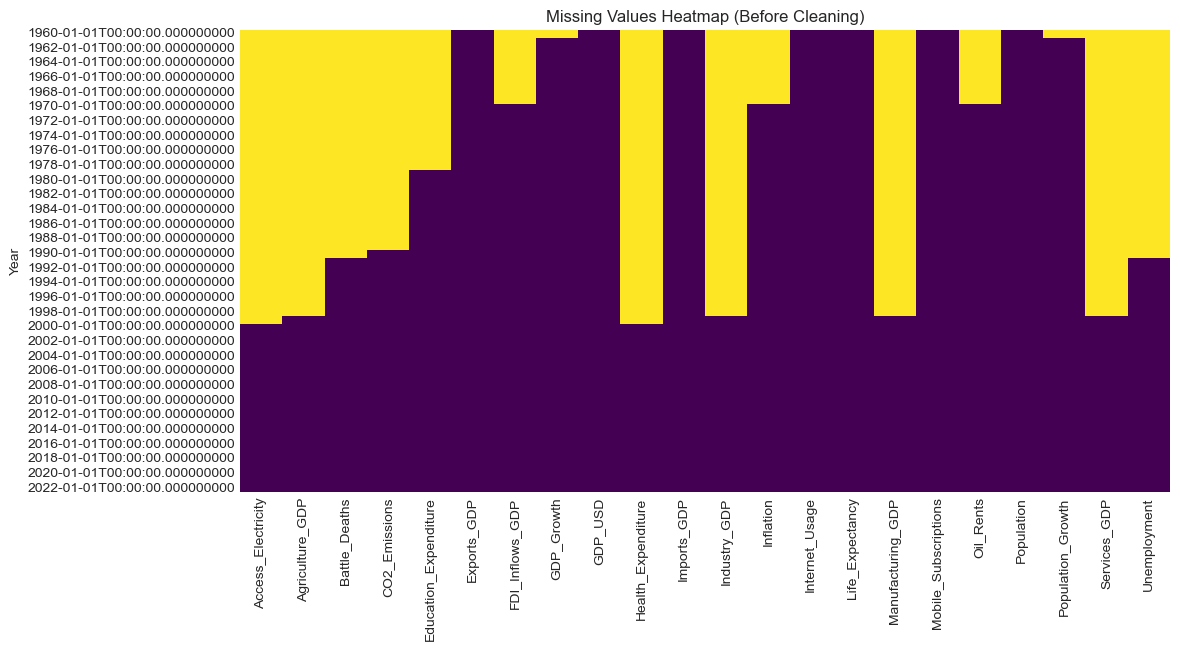

Access_Electricity       40
Agriculture_GDP          39
Battle_Deaths            31
CO2_Emissions            30
Education_Expenditure    19
Exports_GDP               0
FDI_Inflows_GDP          10
GDP_Growth                1
GDP_USD                   0
Health_Expenditure       40
Imports_GDP               0
Industry_GDP             39
Inflation                10
Internet_Usage            0
Life_Expectancy           0
Manufacturing_GDP        39
Mobile_Subscriptions      0
Oil_Rents                10
Population                0
Population_Growth         1
Services_GDP             39
Unemployment             31
dtype: int64


In [4]:
# Check missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Before Cleaning)')
plt.show()

print(df.isnull().sum())

In [5]:
# 1. Linear Interpolation for time-continuous variables
df_imputed = df.interpolate(method='linear', limit_direction='both')

# 2. KNN Imputation for remaining gaps (if any)
imputer = KNNImputer(n_neighbors=5)
df_imputed[:] = imputer.fit_transform(df_imputed)

# Verify no missing values remain
print(f"Missing values after imputation: {df_imputed.isnull().sum().sum()}")

Missing values after imputation: 0


## 3. Feature Construction

We will create new features to capture more economic dynamics:
- **Trade Balance**: Exports - Imports
- **Trade Openness**: (Exports + Imports) / GDP
- **Lag features**: Previous year's values for key indicators (GDP Growth, Inflation).
- **Rolling Averages**: 3-year rolling average for volatile metrics.

In [6]:
# Economic Ratios
df_imputed['Trade_Balance_GDP'] = df_imputed['Exports_GDP'] - df_imputed['Imports_GDP']
df_imputed['Trade_Openness'] = df_imputed['Exports_GDP'] + df_imputed['Imports_GDP']

# Non-Manufacturing Industry
df_imputed['Industry_Non_Mfg_GDP'] = df_imputed['Industry_GDP'] - df_imputed['Manufacturing_GDP']

# Lag Features (1 Year Lag)
lag_cols = ['GDP_Growth', 'Inflation', 'Oil_Rents']
for col in lag_cols:
    df_imputed[f'{col}_Lag1'] = df_imputed[col].shift(1)

# Rolling Averages (3 Year Window)
roll_cols = ['GDP_Growth', 'Inflation']
for col in roll_cols:
    df_imputed[f'{col}_Roll3'] = df_imputed[col].rolling(window=3).mean()

# Drop rows with NaN created by lag/rolling (first few years)
df_imputed = df_imputed.dropna()

df_imputed.head()

,Access_Electricity,Agriculture_GDP,Battle_Deaths,CO2_Emissions,Education_Expenditure,Exports_GDP,FDI_Inflows_GDP,GDP_Growth,GDP_USD,Health_Expenditure,...,Services_GDP,Unemployment,Trade_Balance_GDP,Trade_Openness,Industry_Non_Mfg_GDP,GDP_Growth_Lag1,Inflation_Lag1,Oil_Rents_Lag1,GDP_Growth_Roll3,Inflation_Roll3
Year,,,,,,,,,,,,,,,,,,,,,
1962-01-01,98.64003,11.10698,34.0,62936.9,7.18201,19.793873,1.647364,-19.685042,2.001445e+09,3.489033,...,38.9785,20.6,-1.024774,40.612519,9.759996,-13.605441,6.6,7.1619,-15.631975,6.6
1963-01-01,98.64003,11.10698,34.0,62936.9,7.18201,24.684682,1.647364,34.313729,2.702982e+09,3.489033,...,38.9785,20.6,-12.140833,61.510197,9.759996,-19.685042,6.6,7.1619,0.341082,6.6
1964-01-01,98.64003,11.10698,34.0,62936.9,7.18201,25.084059,1.647364,5.839413,2.909316e+09,3.489033,...,38.9785,20.6,-4.355704,54.523821,9.759996,34.313729,6.6,7.1619,6.822700,6.6
1965-01-01,98.64003,11.10698,34.0,62936.9,7.18201,22.603944,1.647364,6.206898,3.136284e+09,3.489033,...,38.9785,20.6,-3.229135,48.437022,9.759996,5.839413,6.6,7.1619,15.453347,6.6
1966-01-01,98.64003,11.10698,34.0,62936.9,7.18201,25.986198,1.647364,-4.804971,3.039859e+09,3.489033,...,38.9785,20.6,1.332626,50.639770,9.759996,6.206898,6.6,7.1619,2.413780,6.6


## 4. Feature Transformation

Some economic variables like `GDP_USD` and `Population` often follow a power law or exponential distribution. Log transformation helps stabilize variance.

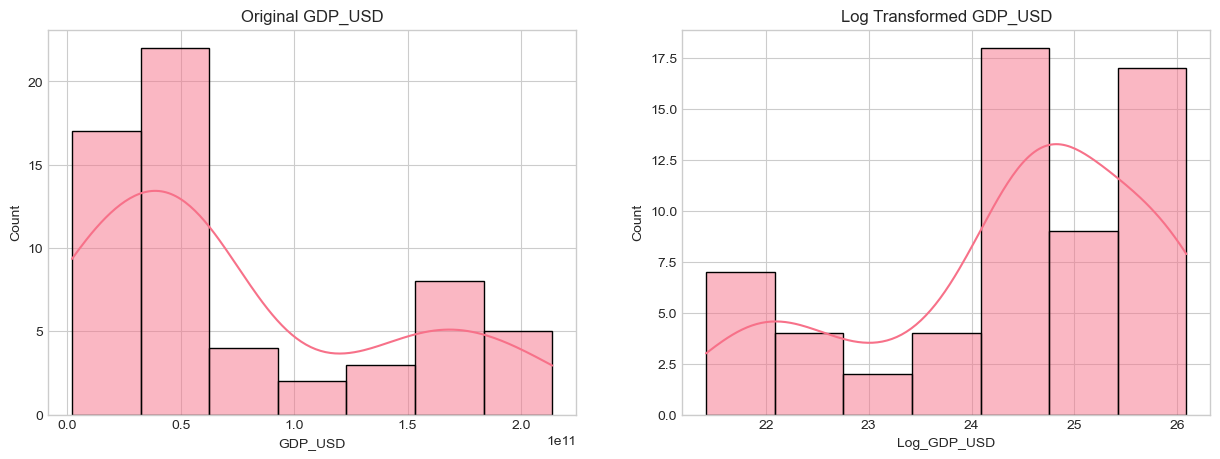

In [7]:
skewed_features = ['GDP_USD', 'Population', 'CO2_Emissions']

for col in skewed_features:
    df_imputed[f'Log_{col}'] = np.log1p(df_imputed[col])

# Visualize distributions before and after
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_imputed['GDP_USD'], kde=True, ax=axes[0]).set_title('Original GDP_USD')
sns.histplot(df_imputed['Log_GDP_USD'], kde=True, ax=axes[1]).set_title('Log Transformed GDP_USD')
plt.show()

## 5. Feature Selection

We investigate the correlation matrix to identify highly correlated features (multicollinearity) which might affect model performance.

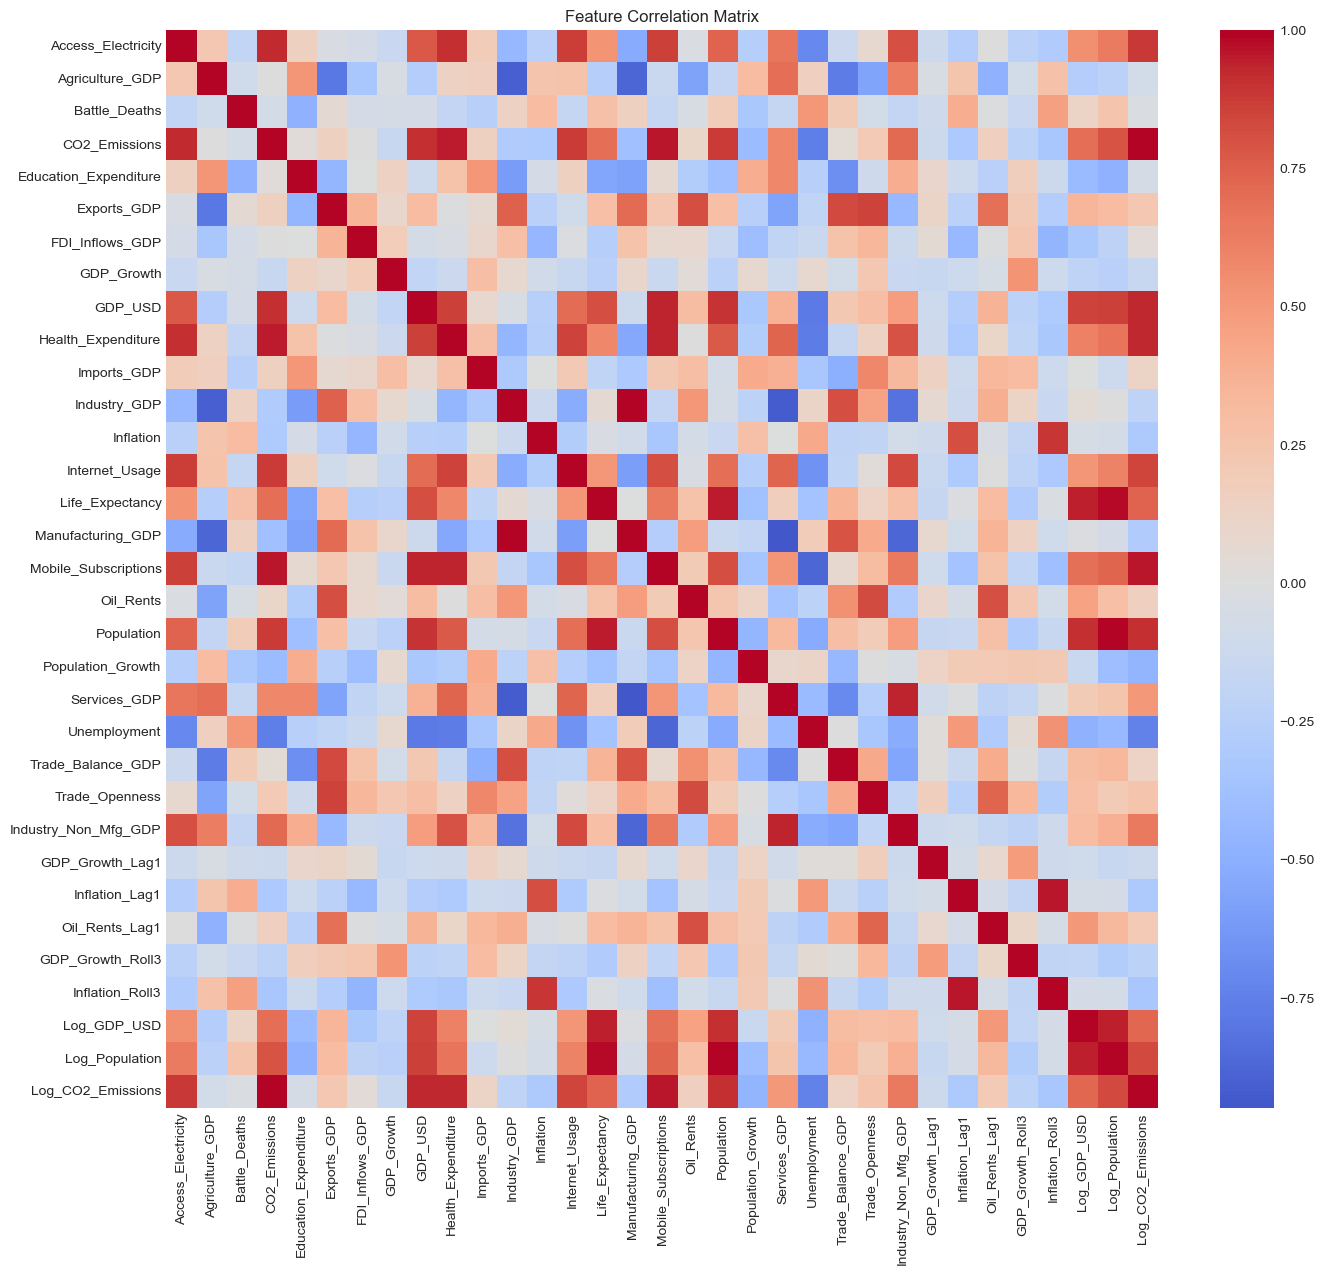

In [8]:
# Correlation Matrix
corr_matrix = df_imputed.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [9]:
# Identifying High Correlations (> 0.9)
high_corr_var = np.where(np.abs(corr_matrix) > 0.9)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                 for x, y in zip(*high_corr_var) if x != y and x < y]

print("Top Highly Correlated Pairs:")
for var1, var2, corr in high_corr_var[:10]:
    print(f"{var1} - {var2}: {corr:.2f}")

Top Highly Correlated Pairs:
Access_Electricity - CO2_Emissions: 0.92
Access_Electricity - Health_Expenditure: 0.90
Agriculture_GDP - Industry_GDP: -0.91
CO2_Emissions - GDP_USD: 0.91
CO2_Emissions - Health_Expenditure: 0.95
CO2_Emissions - Mobile_Subscriptions: 0.96
CO2_Emissions - Log_CO2_Emissions: 0.99
GDP_USD - Mobile_Subscriptions: 0.94
GDP_USD - Population: 0.90
GDP_USD - Log_CO2_Emissions: 0.93


## 6. Export Data

Saving the fully processed data for the next stage (Modeling).

In [10]:
output_path = '../data/processed/algeria_featured.csv'
df_imputed.to_csv(output_path)
print(f"Processed dataset saved to {output_path}")

Processed dataset saved to ../data/processed/algeria_featured.csv
